In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Main Libraries


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
import seaborn as sns
from sklearn import metrics

In [6]:
tf.keras.backend.clear_session() #clean session

# Data Loading

In [7]:
main_path = "/content/drive/MyDrive/Real_fake"

train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')

As we can see, each directory contains two subfolders: fake and real.

In [8]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Valid_dir Subfolders: ", os.listdir(valid_dir))
print("Test_dir Subfolders: ", os.listdir(test_dir))

Train_dir Subfolders:  ['fake', 'real']
Valid_dir Subfolders:  ['fake', 'real']
Test_dir Subfolders:  ['fake', 'real']


# Short EDA - Exploratory Data Analysis
Create a dictionary with three keys:
* **folder**: train, validation and test folders
* **image_path**: path of the images
* **label**: image's label (fake or real)    

In [9]:
images_df = {
    "folder":[],
    "image_path":[],
    "label":[]
}

for folder in os.listdir(main_path): #iterate on each train, valid and test folder
    for label in os.listdir(main_path + "/" + folder): #iterate on fake and real folders (labels)
        for img in glob.glob(main_path + "/" + folder + "/" + label + "/*.jpg"):
            images_df["folder"].append(folder)
            images_df["image_path"].append(img)
            images_df["label"].append(label)

In [10]:
images_df = pd.DataFrame(images_df)

In [11]:
images_df

,folder,image_path,label
0,test,/content/drive/MyDrive/Real_fake/test/fake/5LE...,fake
1,test,/content/drive/MyDrive/Real_fake/test/fake/5JY...,fake
2,test,/content/drive/MyDrive/Real_fake/test/fake/5SZ...,fake
3,test,/content/drive/MyDrive/Real_fake/test/fake/5H5...,fake
4,test,/content/drive/MyDrive/Real_fake/test/fake/5I3...,fake
...,...,...,...
37997,train,/content/drive/MyDrive/Real_fake/train/real/02...,real
37998,train,/content/drive/MyDrive/Real_fake/train/real/02...,real
37999,train,/content/drive/MyDrive/Real_fake/train/real/02...,real
38000,train,/content/drive/MyDrive/Real_fake/train/real/02...,real


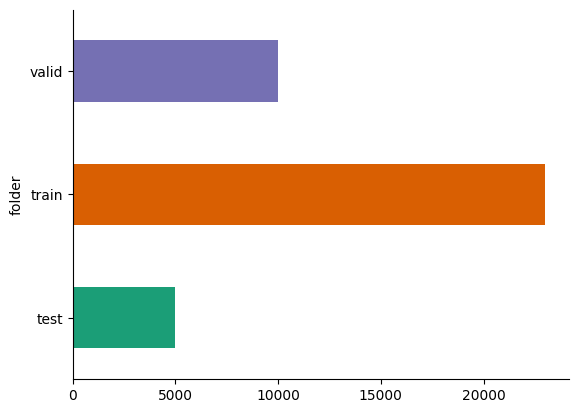

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
images_df.groupby('folder').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### Labels distribution

In [13]:
real_grouped_df = images_df[images_df['label'] == "real"].groupby('folder')
fake_grouped_df = images_df[images_df['label'] == "fake"].groupby('folder')

In [14]:
real_grouped_df.size()

folder
test      2500
train    11500
valid     5000
dtype: int64

In [15]:
fake_grouped_df.size()

folder
test      2500
train    11502
valid     5000
dtype: int64

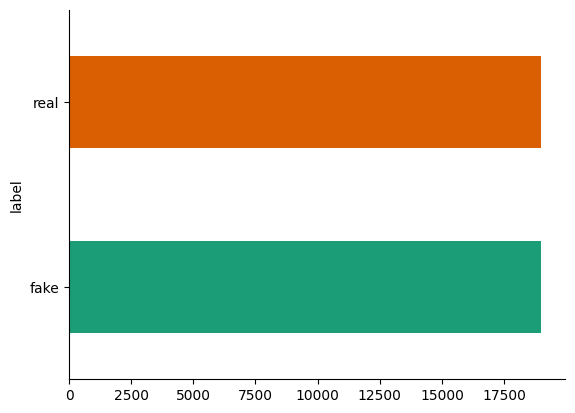

In [16]:
images_df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Data Preparation for visualization and training
## Data Augmentation


In [17]:
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                                  rescale=1./255.,
                                  horizontal_flip=True,
                                  )

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

Important! test_ds prediction and train_ds.classes (ground-truth) **will be not alligned** with suffle=True, so I need to disable shuffle for the test set.

In [18]:
train_ds = image_train_gen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
)

valid_ds = image_gen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    shuffle=False) #shuffle disabled

Found 23002 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [19]:
def plot_images(img, label):
    plt.figure(figsize=[12, 12])
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if label[i] == 0:
            plt.title("Fake")
        else:
            plt.title("Real")

# Data Visualization

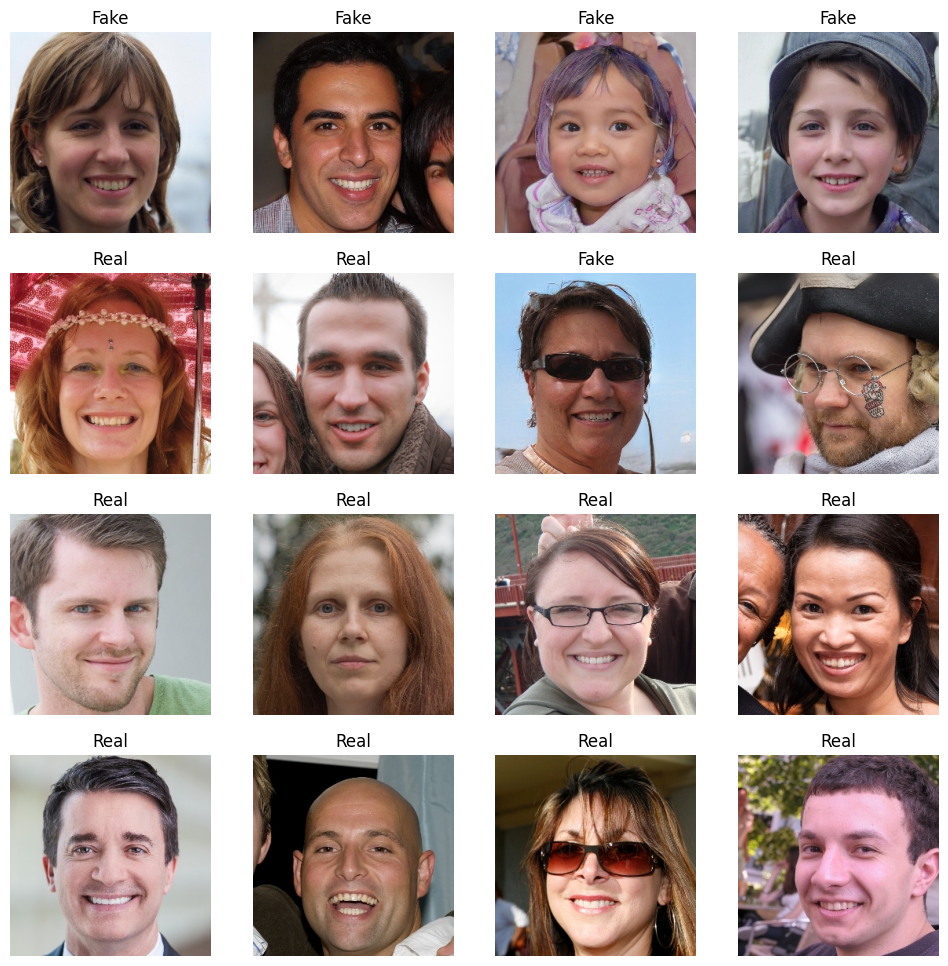

In [20]:
img,lbl = next(train_ds)
plot_images(img,lbl)


It's visible that all the value are scaled.

In [ ]:
for img, label in train_ds:
    print("Values: ", img[0])
    print("Label: ", label[0])
    break

Values:  [[[0.53333336 0.49803925 0.5019608 ]
  [0.5137255  0.4784314  0.48235297]
  [0.4901961  0.454902   0.45882356]
  ...
  [0.3803922  0.35686275 0.35686275]
  [0.4039216  0.3803922  0.3803922 ]
  [0.42352945 0.40000004 0.40000004]]

 [[0.50980395 0.47450984 0.4784314 ]
  [0.5019608  0.4666667  0.47058827]
  [0.4901961  0.454902   0.45882356]
  ...
  [0.37254903 0.34901962 0.34901962]
  [0.38823533 0.3647059  0.3647059 ]
  [0.4039216  0.3803922  0.3803922 ]]

 [[0.48627454 0.46274513 0.46274513]
  [0.48627454 0.46274513 0.46274513]
  [0.48627454 0.46274513 0.46274513]
  ...
  [0.36862746 0.34509805 0.34509805]
  [0.37647063 0.3529412  0.3529412 ]
  [0.3803922  0.35686275 0.35686275]]

 ...

 [[0.06666667 0.05882353 0.07843138]
  [0.07450981 0.06666667 0.08627451]
  [0.07843138 0.07058824 0.09019608]
  ...
  [0.9294118  0.9568628  1.        ]
  [0.8862746  0.92549026 0.9725491 ]
  [0.86274517 0.90196085 0.9490197 ]]

 [[0.07058824 0.0627451  0.08235294]
  [0.07843138 0.07058824 0.0

Let's print the input shape:
- 64 is the batch size
- 256s are the pixel's values.
- 3 are the channel (rgb)

In [ ]:
for img, label in train_ds:
    print(img.shape)
    print(label.shape)
    break

(64, 256, 256, 3)
(64,)


In [ ]:
train_ds.class_indices

{'fake': 0, 'real': 1}

In [ ]:
input_shape = (256, 256, 3) #define the input shape of our data

# CNN model architecture (DenseNet121)

In [ ]:
#create the model's architecture and compile it
def get_model(input_shape):

    input = tf.keras.Input(shape=input_shape)

    densenet = tf.keras.applications.DenseNet121( weights="imagenet", include_top=False, input_tensor = input)

    x = tf.keras.layers.GlobalAveragePooling2D()(densenet.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x) #binary classification

    model = tf.keras.Model(densenet.input, output)

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model


In [ ]:
model_ft = get_model(input_shape)

model_ft.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  

In [ ]:
tf.keras.utils.plot_model(model_ft, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

Let's define the Callbacks
**ModelCheckpoint** callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
In this case, we don't have to worry about training for too long and overfitting the training set.

In [ ]:
checkpoint_filepath = "model_cp.h5"

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', #minimize the loss value
    save_best_only=True)

The **EarlyStopping** callback stops training when a monitored metric (in this case val_loss) has stopped improving (in this case decreasing).

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=5,
                                                     restore_best_weights=True,
                                                    )

**ReduceOnPlateau** callback reduces learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=3)

# Training

In [ ]:
history_ft = model_ft.fit(train_ds,
                       epochs = 10,
                       validation_data = valid_ds,
                       callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr])

Epoch 1/10
360/360 [==============================] - 354s 984ms/step - loss: 0.0084 - accuracy: 0.9976 - val_loss: 0.0176 - val_accuracy: 0.9939 - lr: 2.0000e-04
Epoch 2/10
360/360 [==============================] - 391s 1s/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.0179 - val_accuracy: 0.9939 - lr: 2.0000e-04
Epoch 3/10
360/360 [==============================] - 354s 982ms/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 0.0691 - val_accuracy: 0.9786 - lr: 2.0000e-04
Epoch 4/10
360/360 [==============================] - 354s 983ms/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.0167 - val_accuracy: 0.9942 - lr: 2.0000e-04
Epoch 5/10
360/360 [==============================] - 355s 985ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.0388 - val_accuracy: 0.9866 - lr: 2.0000e-04
Epoch 6/10
360/360 [==============================] - 353s 981ms/step - loss: 0.0069 - accuracy: 0.9974 - val_loss: 0.0806 - val_accuracy: 0.9768 - lr: 2.0000e-04
Epoch 7/10
360/360 [=====

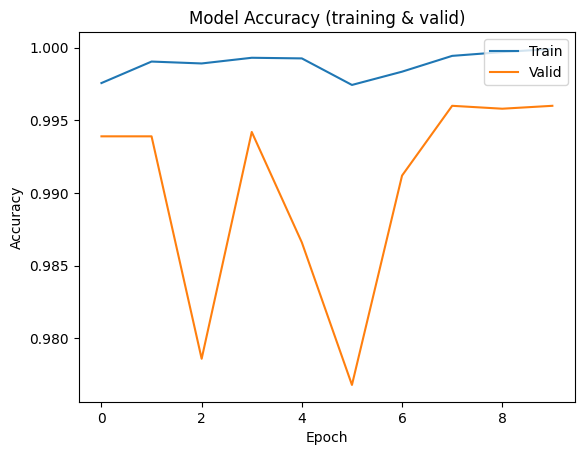

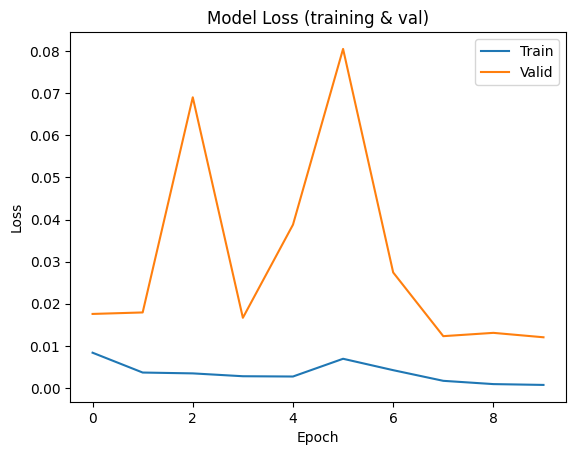

In [ ]:
plt.plot(history_ft.history['accuracy'])
plt.plot(history_ft.history['val_accuracy'])
plt.title('Model Accuracy (training & valid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()


plt.plot(history_ft.history['loss'])
plt.plot(history_ft.history['val_loss'])
plt.title('Model Loss (training & val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model_ft.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

79/79 [==============================] - 1385s 18s/step - loss: 0.0105 - accuracy: 0.9964
Test Loss: 0.010506383143365383
Test Accuracy: 0.996399998664856


In [ ]:
model_ft.save('/content/drive/MyDrive/capstone.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
filepath = '/content/drive/MyDrive/capstone.h5'
model = tf.keras.saving.load_model(filepath, custom_objects=None, compile=True, safe_mode=True)



In [21]:
predicted_labels = model.predict(test_ds)

79/79 [==============================] - 1815s 23s/step


In [23]:
true_labels = test_ds.classes

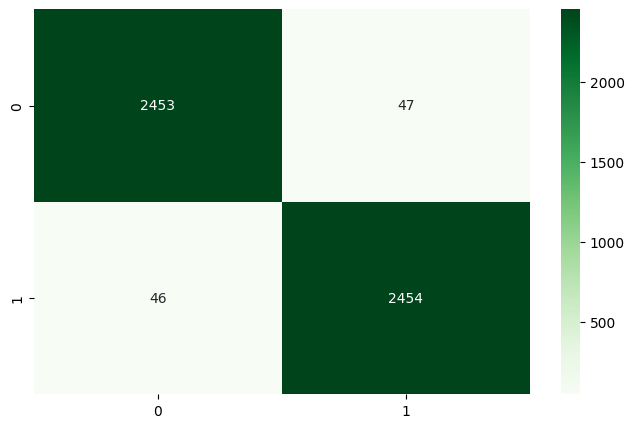

In [24]:
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(true_labels, predicted_labels.round()), annot = True,fmt="d",cmap = "Greens")
plt.show()


1/1 [==============================] - 3s 3s/step


Text(0.5, 1.0, 'This image is 99.97% Fake and 0.03% Real.')

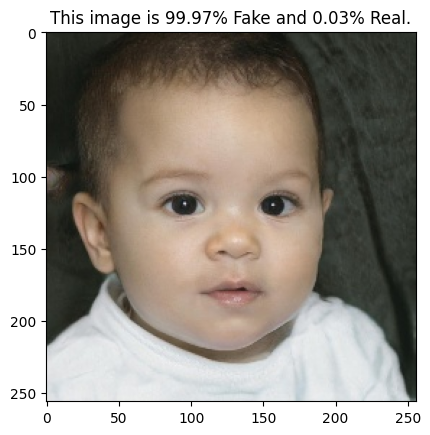

In [25]:
test_image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/Real_fake/valid/fake/00483R5CC4.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)


test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

Saving download (2).jpeg to download (2).jpeg
1/1 [==============================] - 0s 29ms/step


Text(0.5, 1.0, 'This image is 0.26% Fake and 99.74% Real.')

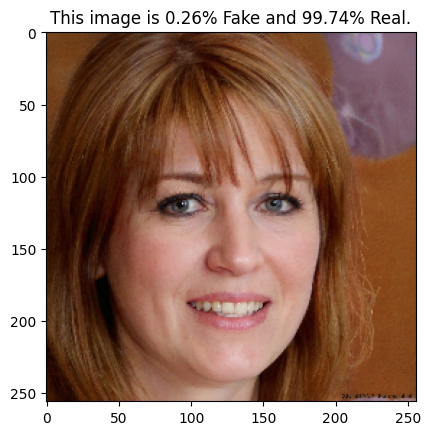

In [31]:
from google.colab import files

# Upload an image file
uploaded = files.upload()
# Get the uploaded file name
file_name = list(uploaded.keys())[0]

# Get the file path
file_path = f'/content/{file_name}'

test_image = tf.keras.preprocessing.image.load_img(file_path, target_size=(256, 256, 3))
plt.imshow(test_image)


test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")